# RBIG Demo

In [15]:
!pip install "git+https://github.com/IPL-UV/rbig.git"

import numpy as np
import warnings
from time import time
from rbig.rbig import RBIG, entropy
# from rbig.model import RBIG
from sklearn.model_selection import train_test_split
from sklearn.utils import check_random_state
import matplotlib.pyplot as plt
plt.style.use('ggplot')
warnings.filterwarnings('ignore') # get rid of annoying warnings

%matplotlib inline
%load_ext autoreload
%autoreload 2

  Cloning https://github.com/IPL-UV/rbig.git to /tmp/pip-req-build-pgvzutbt
  Running command git clone -q https://github.com/IPL-UV/rbig.git /tmp/pip-req-build-pgvzutbt
  Created wheel for py-rbig: filename=py_rbig-0.0.1-cp36-none-any.whl size=31674 sha256=f022cd22e5d24b7d78e6d7695ef92b901140074eaf3e02d96b43b4a9ea26fbef
  Stored in directory: /tmp/pip-ephem-wheel-cache-ijs99om5/wheels/44/83/b6/1b809fcf994755ddd81da1fb7a4e11089ac23861253e5881b6
Successfully built py-rbig
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


#### Toy Data

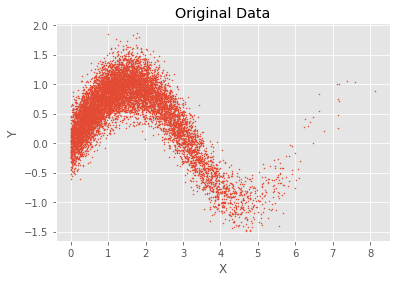

In [16]:
seed = 123
rng = np.random.RandomState(seed=seed)

num_samples = 10000
x = np.abs(2 * rng.randn(1, num_samples))
y = np.sin(x) + 0.25 * rng.randn(1, num_samples)
data = np.vstack((x, y)).T

fig, ax = plt.subplots()
ax.scatter(data[:, 0], data[:, 1], s=1)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('Original Data')
plt.show()

In [19]:
data.shape

(10000, 2)

## RBIG Fitting

In [25]:
%%time 

n_layers = 1000
rotation_type = 'pca'
random_state = 123
zero_tolerance = 1

# Initialize RBIG class
rbig_model = RBIG(n_layers=n_layers, rotation_type=rotation_type, 
                  random_state=random_state, zero_tolerance=zero_tolerance)

# transform data
data_trans = rbig_model.fit_transform(data)

CPU times: user 66 ms, sys: 0 ns, total: 66 ms
Wall time: 66.2 ms


### Transform Data into Gaussian

(10000, 2)


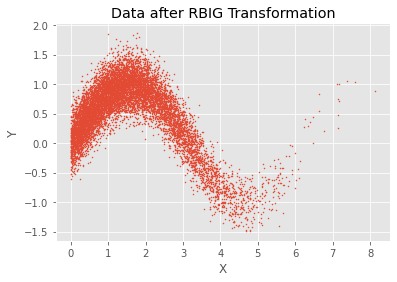

In [28]:
print(data_trans.shape)
fig, ax = plt.subplots()
ax.scatter(data_trans[:, 0], data_trans[:, 1], s=1)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('Data after RBIG Transformation')
plt.show()

### Invertible

In [6]:
%%time
# transform data
data_approx = rbig_model.inverse_transform(data_trans)

# check approximation
np.testing.assert_array_almost_equal(data, data_approx)

CPU times: user 1.45 ms, sys: 102 µs, total: 1.56 ms
Wall time: 1.56 ms


#### Check Residuals

In [7]:
data_approx = rbig_model.inverse_transform(data_trans)
residual = np.abs(data - data_approx).sum().sum()

print(f'Residual from Original and Transformed: {residual:.2e}')

Residual from Original and Transformed: 0.00e+00


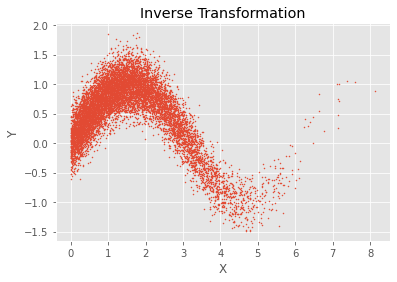

In [8]:
fig, ax = plt.subplots()
ax.scatter(data_approx[:, 0], data_trans[:, 1], s=1)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('Inverse Transformation')
plt.show()

### Information Reduction

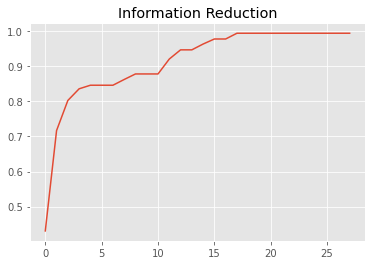

In [18]:
residual_info = rbig_model.residual_info

fig, ax = plt.subplots()
ax.plot(np.cumsum(rbig_model.residual_info))
ax.set_title('Information Reduction')
plt.show()

### Generated Synthetic Data

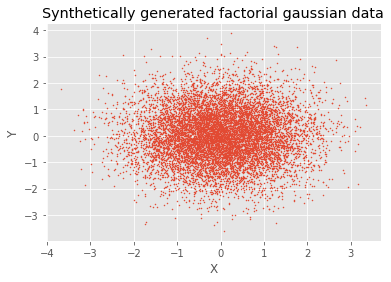

In [10]:
data_synthetic = rng.randn(data.shape[0], data.shape[1])

fig, ax = plt.subplots()
ax.scatter(data_synthetic[:, 0], data_synthetic[:, 1], s=1)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('Synthetically generated factorial gaussian data')
plt.show()

### Synthesize New Data from RBIG Model

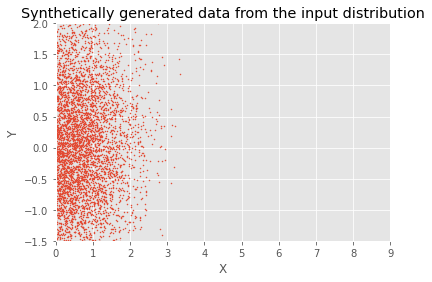

In [11]:
data_original_synthetic = rbig_model.inverse_transform(data_synthetic)

fig, ax = plt.subplots()
ax.scatter(data_original_synthetic[:, 0], data_original_synthetic[:, 1], s=1)
# ax.scatter(data[:, 0], data[:, 1], s=1)

ax.set_ylim([-1.5, 2.0])
ax.set_xlim([0.0, 9.0])
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('Synthetically generated data from the input distribution')
plt.show()

### Jacobian

In [12]:
%%time

jacobian = rbig_model.jacobian(data, return_X_transform=False)

print(jacobian.shape)

print(f"Jacobian - min: {jacobian.min():.3e}, max: {jacobian.max():.3e}")

(10000, 2, 2)
Jacobian - min: 0.000e+00, max: 1.000e+00
CPU times: user 600 µs, sys: 934 µs, total: 1.53 ms
Wall time: 1.33 ms


### Estimating Probabilities with RBIG

In [ ]:
%%time
prob_input, prob_gauss = rbig_model.predict_proba(data, domain='both', n_trials=1)
print(f"Prob Input Domain - min: {prob_input.min():.3e}, max: {prob_input.max():.3e}")
print(f"Prob Gauss Domain - min: {prob_gauss.min():.3e}, max: {prob_gauss.max():.3e}")
print(f"Det:: {rbig_model.det_jacobians:.3e}")

Prob Input Domain - min: 2.713e-16, max: 1.588e-01
Prob Gauss Domain - min: 2.713e-16, max: 1.588e-01
Det:: 1.000e+00
CPU times: user 6.96 ms, sys: 929 µs, total: 7.89 ms
Wall time: 6.88 ms


### Original Data with Probabilities

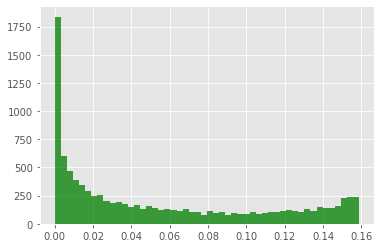

In [ ]:
fig, ax = plt.subplots()
ax.hist(prob_input, 50, facecolor='green', alpha=0.75)
plt.show()

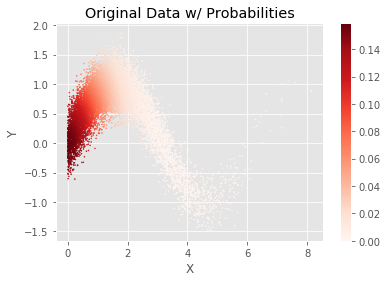

In [ ]:
fig, ax = plt.subplots()

h = ax.scatter(data[:, 0], data[:, 1], s=1, c=prob_input, cmap='Reds')

ax.set_xlabel('X')
ax.set_ylabel('Y')
cbar = plt.colorbar(h, )
ax.set_title('Original Data w/ Probabilities')
plt.show()

### Probability in Gaussian Domain

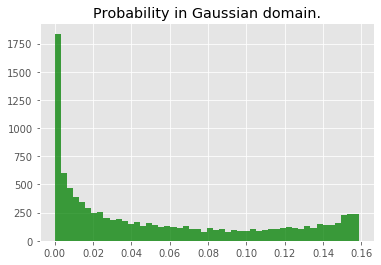

In [ ]:
# Plot the probability of the data in the Gaussian Domain
fig, ax = plt.subplots()

n, bins, patches = ax.hist(prob_gauss, 50, facecolor='green', alpha=0.75)
ax.set_title('Probability in Gaussian domain.')
plt.show()

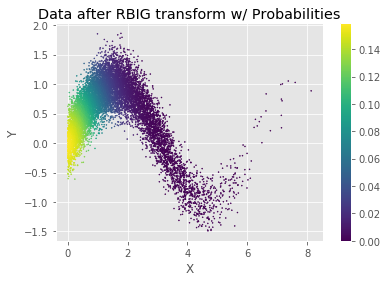

In [ ]:
# Plot the Probabilities of the data using colors
fig, ax = plt.subplots()
g = ax.scatter(data_trans[:, 0], data_trans[:, 1],
               s=1, c=prob_gauss)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('Data after RBIG transform w/ Probabilities')
plt.colorbar(g)
plt.show()

## Benchmarks

In [ ]:
data = np.random.randn(100_000, 100)

In [ ]:
%%time 

n_layers = 1000
rotation_type = 'pca'
random_state = 123
zero_tolerance = 10

# Initialize RBIG class
rbig_model = RBIG(
    n_layers=n_layers, 
    rotation_type=rotation_type, 
    random_state=random_state, 
    zero_tolerance=zero_tolerance,
    pdf_resolution=50,
)

# transform data
data_trans = rbig_model.fit_transform(data)

CPU times: user 1min 59s, sys: 28.2 s, total: 2min 28s
Wall time: 31.6 s


In [ ]:
rbig_model.n_layers

0

In [ ]:
from rbig.model import RBIG as RBIG11

In [ ]:
%%time 
n_layers = 1000
rotation_type = 'pca'
random_state = 123
zero_tolerance = 60
verbose=0
method = 'custom'

# Initialize RBIG class
rbig_model = RBIG11(
    n_layers=n_layers, 
    rotation_type=rotation_type, 
    random_state=random_state, 
    zero_tolerance=zero_tolerance,
    verbose=verbose,
    method=method,
    pdf_resolution=50,
)

# transform data
data_trans = rbig_model.fit_transform(data)

CPU times: user 8min 13s, sys: 1min 25s, total: 9min 38s
Wall time: 1min 58s


In [ ]:
residual_info = rbig_model.residual_info
plt.

In [ ]:
%%time

data_inverted = rbig_model.inverse_transform(data_trans)

CPU times: user 4min 10s, sys: 29.9 s, total: 4min 40s
Wall time: 32.4 s


In [ ]:
%%time
prob_input, prob_gauss = rbig_model.predict_proba(data, domain='both', n_trials=1)

KeyboardInterrupt: 

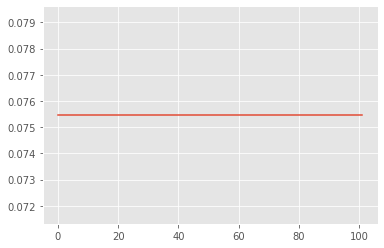

In [ ]:
plt.plot(np.cumsum(rbig_model.residual_info))